# Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

import os
import json

In [30]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

# Load data

In [31]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data.tail()

,sex,treatment,tissue,injectionVolume,massInfo,componentGroupName,expectedRt,area,isArea,areaRatio,retentionTime,signalNoise,tissueWeightMg,normalizedArea,sampleName,isNormalizationFactor,normfactor
57259,Female,Deltamethrin,Cortex,10,301.0 / 257.0,PUFA,2.65,9.494550e+05,429984.07819,2.208117,2.722196,70.891580,40,5.520292,18,False,11
57260,Female,Deltamethrin,Cortex,10,327.0 / 283.0,PUFA,2.82,1.502219e+08,429984.07819,349.366103,2.558918,284.097687,40,873.415258,18,False,11
57261,Female,Deltamethrin,Cortex,10,329.0 / 285.0,PUFA,2.80,1.058937e+07,429984.07819,24.627343,2.543228,176.422195,40,61.568359,18,False,11
57262,Female,Deltamethrin,Cortex,10,331.0 / 287.0,PUFA,2.79,1.978464e+06,429984.07819,4.601250,2.563011,83.911044,40,11.503124,18,False,11
57263,Female,Deltamethrin,Cortex,10,303.0 / 259.0,PUFA,2.81,1.463774e+08,429984.07819,340.425180,2.559217,270.128505,40,851.062950,18,False,11


# Manipulate data

Extract log value of the target variable

In [32]:
columns_to_transform = ['areaRatio']

for c in columns_to_transform:
    data['log'+c[0].capitalize()+c[1:]] = data[c].apply(lambda x: np.log(x))

# Figures

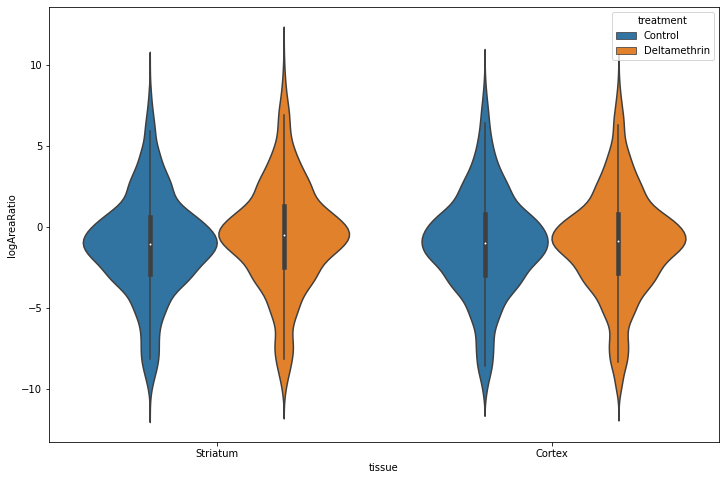

In [33]:
plt.figure(figsize=(12,8))
sns.violinplot(data=data, x='tissue', hue='treatment', y='logAreaRatio')
plt.show()

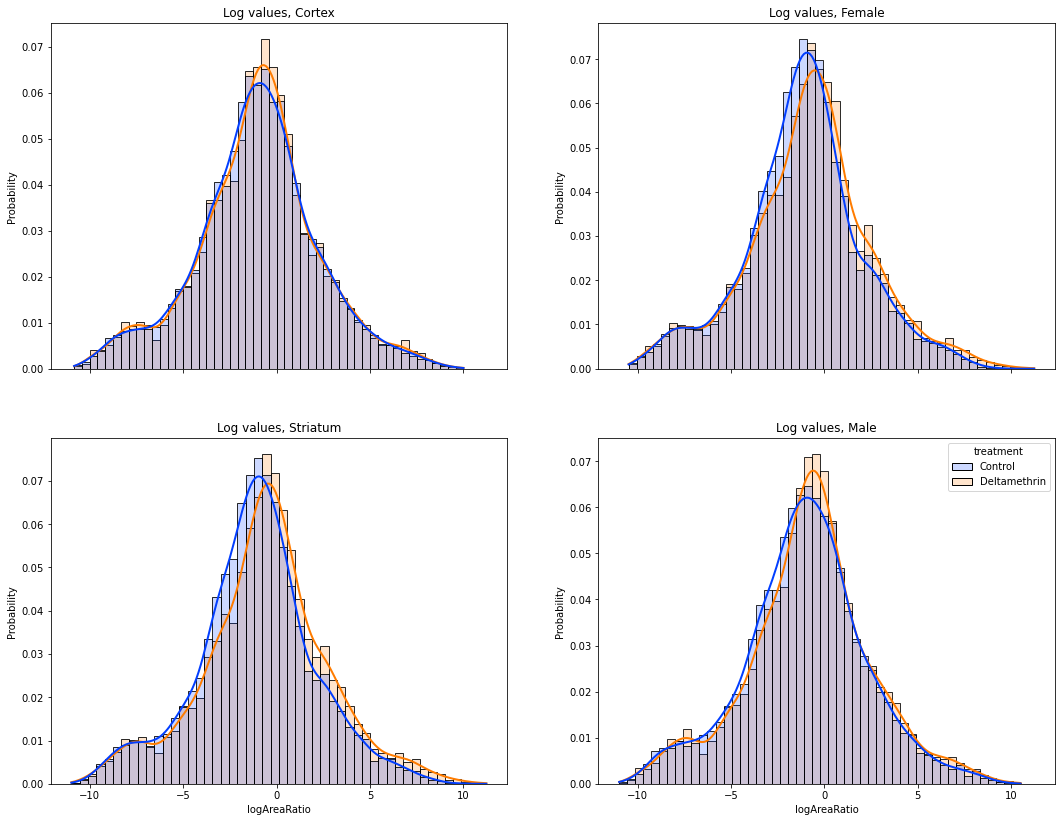

In [34]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(18,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['tissue'] == 'Cortex'], x='logAreaRatio', hue='treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Cortex')
sns.histplot(data=data[data['tissue'] == 'Striatum'], x='logAreaRatio', hue='treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum')

sns.histplot(data=data[data['sex'] == 'Female'], x='logAreaRatio', hue='treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Female')
sns.histplot(data=data[data['sex'] == 'Male'], x='logAreaRatio', hue='treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

Data divided by tissue

In [35]:
tissue = ['Striatum','Cortex']
gender = ['Female', 'Male']
var_name = 'areaRatio'

data_normalized = data[data['isNormalizationFactor'] == False]

for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 2.38e-27
Tissue: Cortex. P-value: 1.99e-01


Data divided by gender

In [36]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['sex']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: Female. P-value: 8.72e-14
Gender: Male. P-value: 3.26e-06


## T-test applied on the data with log normalization

Data divided by tissue

In [37]:
var_name = 'logAreaRatio'

for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 2.23e-22
Tissue: Cortex. P-value: 3.14e-01


Data divided by gender

In [38]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['sex']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: Female. P-value: 5.85e-11
Gender: Male. P-value: 1.95e-05


## Two-way ANOVA on log normalized data

In [42]:
model = ols('logAreaRatio ~ C(sex) + C(treatment) + C(tissue) + C(sex):C(treatment) + C(tissue):C(treatment)', data=data_normalized).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(sex),6.627113,1.0,0.621733,4.304099e-01
C(treatment),622.522821,1.0,58.402983,2.196490e-14
C(tissue),191.664073,1.0,17.981274,2.237272e-05
C(sex):C(treatment),26.035955,1.0,2.442605,1.180901e-01
C(tissue):C(treatment),404.384124,1.0,37.937949,7.391703e-10
Residual,334279.814181,31361.0,NaN,NaN
